# Import rule-based 

In [2]:
import edsnlp
import spacy
nlp = spacy.blank('fr')
nlp.add_pipe("eds.sentences")
from spacy.language import Language
from spacy.pipeline import SentenceRecognizer
@Language.factory('senter')
def senter(nlp, name):
    return SentenceRecognizer

senter = nlp.add_pipe("senter")

/donnees/home/dong/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
2024-08-27 11:09:57.276896: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-27 11:09:57.857528: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in p

In [41]:
# import 
# classical
import pandas as pd
import pyodbc
import numpy as np
import sys
import pickle as pkl
import os
# home made
sys.path.insert(0,'../toolkit_classic_ml')
sys.path.insert(0,'../toolkit_ehop_extraction')
sys.path.insert(0,'../edsnlp')

In [3]:
import unicodedata
import unidecode
import re

In [ ]:
import os
 
os.environ["PYSPARK_PYTHON"]="/appli/anaconda/bin/python3"
os.environ["PYTHON_PATH"]="/appli/anaconda/bin/python3"
os.environ["SPARK_HOME"]="/appli/spark-3.1.2-bin-hadoop3.2"

In [ ]:
sc.stop()

I0306 17:09:58.997736 47540 sched.cpp:2174] Asked to stop the driver
I0306 17:09:59.021315 47843 sched.cpp:1207] Stopping framework a7afb729-cd14-4a93-a6e6-f1d5428c1d65-0319


In [ ]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import explode, udf, struct
from pyspark.sql.types import ArrayType, FloatType, StringType, IntegerType, BinaryType
from pyspark.sql.functions import monotonically_increasing_id
import pyspark.sql.functions as F
import pandas as pd


In [7]:
conf = (SparkConf()
        #.set("spark.files.overwrite", "true")
        .setMaster("mesos://lx181:5050") 
        .setAppName("html_parser"))
 
sc = SparkContext(conf = conf)
sqlContext = SQLContext(sc)

24/03/04 10:04:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/04 10:04:39 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
24/03/04 10:04:39 WARN SparkConf: Total executor cores: 40 is not divisible by cores per executor: 7, the left cores: 5 will not be allocated
24/03/04 10:04:40 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/03/04 10:04:40 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/03/04 10:04:40 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
24/03/04 10:04:40 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting por

In [21]:
def uniformed_label(num):
    return str(int(num)-1)[0]

In [22]:
import time

In [23]:
import os
import torch
from transformers import CamembertForSequenceClassification, TrainingArguments, Trainer
from transformers import CamembertModel, CamembertTokenizer
tokenizer = CamembertTokenizer.from_pretrained("/donnees/share/models/camembert-large")
model_taba=CamembertForSequenceClassification.from_pretrained("./taba_model_session_1et2_complete/checkpoint-2844")
l="vésicale à droite. Dans les antécédents pathologiques, on note un tabagisme à 20 paquets année."
tic = time.perf_counter()
inputs = tokenizer(l, max_length=500, truncation=True,return_tensors="pt")
with torch.no_grad():
    staba = uniformed_label(model_taba(**inputs).logits.argmax().item())
toc = time.perf_counter()


In [24]:
toc-tic

0.17100681364536285

## read parquets dans dossier

In [21]:
import os
from spacy.tokens import Doc
Doc.set_extension("meta", default = None, force = True)
c=0
for file in os.listdir("full_corpus_parquets"):
    #print(file)
    if file[-7:]=="parquet":
        head="-".join(file.split("-")[:2])
        c+=1
        corpus = sqlContext.read.parquet(
      'full_corpus_parquets/'+file
        ).repartition(200)
        res = corpus.repartition(1000).toPandas()
        w=open("full_corpus_extrait/"+head+".txt", "w", encoding="utf-8")
        for i,t in enumerate(res.TEXTE_CLEAN):
            ex2 = Doc(nlp.vocab).from_bytes(t)
            ide=ex2._.meta['ID_ENTREPOT']
            w.write("#ID_ENTREPOT:"+str(ide)+"\n")
            for sent in ex2.sents:
                #print(sent)
                w.write(str(sent)+"\n")
            w.write("\n\n")   
        print(str(c)+" finished", end="\r")
        w.close()
        #break

### load meta données file

In [66]:
import pickle
with open('/donnees/share/meta.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

In [120]:
import os
doc_type=dict()
for file in os.listdir("full_corpus_extrait"):
    if file[-4:]==".txt":
        with open("full_corpus_extrait/"+file, "r", encoding="utf-8") as f:
            for l in f.readlines():
                #s=s.strip().lower()
                #s=unidecode.unidecode(s)
                if "#ID_ENTREPOT:" in l :
                    ide=l.replace("#ID_ENTREPOT:", "")
                    meta=loaded_dict[ide.strip()]
                    td=meta['TYPE_DOC']
                    tr=meta['TITRE']
                    tdh=td.split(":")[0]
                    if tr:
                        trh=tr.split("/")[0].strip()
                    else:
                        trh=tr
                    idp=meta['ID_PAT']
                    #doc_type[(td,tr)]=doc_type.get((td,tr),0)+1
                    doc_type[tr]=doc_type.get(tr,0)+1
                    

    #break
            

In [121]:
len(doc_type)

49878

In [122]:
doc_type

{'IRM - Cholangio + Foie': 12,
 'Réalisation actes et soins/IDE / Bracelet identification-surv': 26722,
 'Pancarte / Passage soignant': 115537,
 'Réalisation actes et soins/IDE / Sonde gastrique Réal IDE': 1905,
 'Réalisation actes et soins/IDE / Pst autre-surv': 1490,
 'Bon Orthophon. Post chir.': 23,
 'Validation médicale sortie SSPI': 2948,
 'Pancarte / AS/AP-soins': 42203,
 'Pancarte / Glycémie capillaire': 19975,
 'Réalisation actes et soins/IDE / Hydratation-Incitation': 1625,
 'Compte Rendu APIX': 8806,
 'Réalisation actes et soins/IDE / Alimentation-Collation': 1296,
 'URO_CR_Consultation 16.09.19': 9,
 'Réalisation actes et soins/IDE / Température': 14027,
 'Réalisation actes et soins/IDE / Sortie de SSPI = score et CAT': 906,
 'Réalisation actes et soins/IDE / Réal° KT court surv': 18378,
 'MAL-INF.-Consultat° et HDJ': 482,
 'Compte rendu urgence': 10871,
 '8.04-Fiches spécifiques / ALGOPLUS (SQ)': 659,
 '8.05- Passage bloc/salle interv. / FSI- nettoyage salle': 1159,
 "Compt

In [83]:
sum(list(doc_type.values()))

799470

In [84]:
ltd=sorted(doc_type.items(), key=lambda x:x[1], reverse=True)

In [85]:
ltd

[('Réalisation actes et soins', 273512),
 ('Pancarte', 192713),
 ('Compte Rendu de Consultation', 30216),
 ('8.04-Fiches spécifiques', 14433),
 ('Compte rendu urgence', 10871),
 ('Compte Rendu APIX', 8806),
 ("Compte Rendu d''Hospitalisation", 8044),
 ('URO-Hospit.Evolution quotidienne', 7620),
 ('8.05- Passage bloc', 7372),
 ('8.03-Synthèse', 6539),
 ('Kiné-Suivi', 6156),
 ('Compte-rendu opératoire', 5519),
 ("ANESTH.-CR d'anesthésie", 4032),
 ('Kiné planification', 3705),
 ("8.01-Formalités d'accueil", 3672),
 ('Bon Radio std', 3343),
 ('URO-ECBU préopératoire', 3242),
 ('Kiné Suivi Respi', 3096),
 ("Compte Rendu d'Hospitalisation", 3087),
 ('Validation médicale sortie SSPI', 2948),
 ('Bon Ultrasons', 2910),
 ('Bon Scanner', 2293),
 ('CHIR-Sortie bloc-hospit URO', 2285),
 ('URO-Hospitalisation', 2250),
 ('8.06-Formalités de sortie', 2046),
 ('URO-Hospit.Sortie', 1992),
 ('URO-CRO', 1920),
 ('Prise en charge dietétique', 1876),
 ('URO-Hospit.Entrée', 1752),
 ('URO-Ordonnances PDF', 15

In [144]:
lnb=list()

In [145]:
lpct=list()
for a,b in ltd[:13]:
    lpct.append((a,round(b*100/799470,2)))
    lnb.append(b)

In [146]:
lpct

[('Réalisation actes et soins', 34.21),
 ('Pancarte', 24.11),
 ('Compte Rendu de Consultation', 3.78),
 ('8.04-Fiches spécifiques', 1.81),
 ('Compte rendu urgence', 1.36),
 ('Compte Rendu APIX', 1.1),
 ("Compte Rendu d''Hospitalisation", 1.01),
 ('URO-Hospit.Evolution quotidienne', 0.95),
 ('8.05- Passage bloc', 0.92),
 ('8.03-Synthèse', 0.82),
 ('Kiné-Suivi', 0.77),
 ('Compte-rendu opératoire', 0.69),
 ("ANESTH.-CR d'anesthésie", 0.5)]

In [147]:
s=0
for a,b in ltd[13:]:
    s+=b
print(round(s*100/799470,2))
lnb.append(s)

27.97


In [148]:
lnb

[273512,
 192713,
 30216,
 14433,
 10871,
 8806,
 8044,
 7620,
 7372,
 6539,
 6156,
 5519,
 4032,
 223637]

In [132]:
print(list(range(13)))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


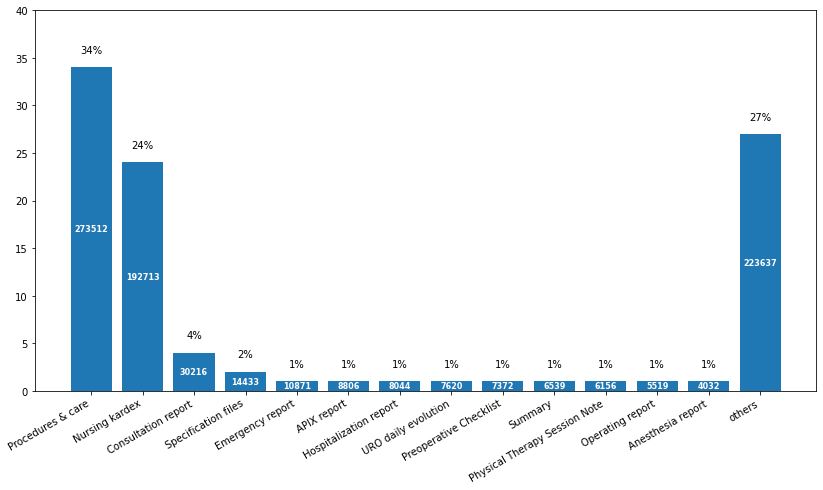

In [152]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (14,7)

x = np.array([a*2.5 for a in range(14)]) 
L= ["Procedures & care", "Nursing kardex", "Consultation report", "Specification files", "Emergency report", "APIX report", "Hospitalization report", 
    "URO daily evolution", "Preoperative Checklist", "Summary", "Physical Therapy Session Note", "Operating report", "Anesthesia report", "others"]
y = np.array([34, 24, 4, 2, 1, 1, 1, 1,1,1,1,1,1,27])




plt.xticks(x, L, rotation=30, horizontalalignment='right')
plt.ylim(ymin=0, ymax=40)
plt.bar(x,y, width=[2]*14)


for i, v in enumerate(lnb):
    plt.text(x[i], 
              y[i]/2, 
              lnb[i], 
              horizontalalignment='center', verticalalignment='center', weight="bold", color="white", fontsize=8)
for i, v in enumerate(y):
    plt.text(x[i], 
              y[i]+1.5, 
              str(y[i])+"%", 
              horizontalalignment='center')
    
plt.savefig('article/types_docs_compsition.png')
plt.show()

In [34]:
list(loaded_dict.items())[0]

('14151157',
 {'ID_ENTREPOT': 14151157,
  'ID_PAT': 1108840,
  'ID_SEJ': 3843558,
  'ID_MVT': None,
  'ID_LOT': Decimal('603'),
  'DATE_MAJ': None,
  'UF': '4009',
  'UF_EXEC': '4009',
  'UM': None,
  'TITRE': 'Lettre patient',
  'TYPE_DOC': 'SILLAGE:LP',
  'DATESIGNATURE': datetime.datetime(2009, 11, 9, 0, 0),
  'AUTEUR': None,
  'INSTANCE_ID': None,
  'AGE_PAT': Decimal('69'),
  'ACTIVITE': None,
  'NIV_CONFID': None,
  'MASQUAGE': None,
  'INVIS_PAT': None})

In [54]:
import edsnlp

In [55]:
import spacy
nlp = spacy.blank('fr')
#import spacy
#nlp = spacy.load("/donnees/share/fr_core_news_md-3.2.0/fr_core_news_md/fr_core_news_md-3.2.0/")
#print("done")
nlp.add_pipe("eds.sentences")
#from spacy.pipeline.senter import DEFAULT_SENTER_MODEL
#config = {"model": DEFAULT_SENTER_MODEL,}
from spacy.language import Language
from spacy.pipeline import SentenceRecognizer
#senter=nlp.add_pipe("senter", config=config)
@Language.factory('senter')
def senter(nlp, name):
    return SentenceRecognizer

senter = nlp.add_pipe("senter")
#nlp.add_pipe("eds.sentences")

In [56]:
import unicodedata
import unidecode
import re

In [18]:
# liste de negation pour les règles d'annotations des symptômes (hypertension, diabètes etc.)
list_neg=["pas ", "pas de ", "pas d'","absence ", "absence de ", "absence d'", "non ", "sans "]
list_neg_post=[" absent", " absente", " non trouve", " non trouvee", 
               " non detecte",  " non detectee", " traite",  " traitee",
               " deja traite", " deja traitee"," pas trouve", " pas trouvee"," pas detecte"," pas detectee"]

In [97]:
# combiner les éléments dans la liste de négation avec les éléments dans la liste des symptômes pour former la négation de la présence de symptôtme
list_hyper=["hypertension", "hypertensive",  "hta", ]
patterns_neg_hyper=[]
for a in list_hyper:
    for b in list_neg:
        patterns_neg_hyper.append(b+a)
    for c in list_neg_post:
        patterns_neg_hyper.append(a+c)
# on obtient une liste qui contient la négation des symptôme, comme "pas hypertensive", "absence d'hypertension" etc.


# preannotate hypertension
#sortir en str -, 0, 1,  qui représentent respectivement "phrase indifférente pour hypertension", "pas d'hypertension" et "avoir hypertension"
def preannotate_hyper(sent):
    

    hyper="-"
    for p in patterns_neg_hyper:
        if " "+p+" " in " "+sent+" ":
            hyper="0"
            return hyper
    for m in list_hyper:
        if " "+m+" " in " "+sent+" ":
            hyper="1"
            return hyper
    return hyper

In [99]:
preannotate_hyper("hta detecte")

'1'

In [90]:
# combiner les éléments dans la liste de négation avec les éléments dans la liste des symptômes pour former la négation de la présence de symptôtme

list_diab=["diabete", "diabetique", "did", "dnid", "dt2"]
patterns_neg_diab=[]
for a in list_diab:
    for b in list_neg:
        patterns_neg_diab.append(b+a)
    for c in list_neg_post:
        patterns_neg_diab.append(a+c)
# on obtient une liste qui contient la négation des symptôme, comme "pas diabetique", "absence de diabete" etc.
        
        
        
        
# preannotate diabete status
#sortir en str -, 0, 1,  qui représentent respectivement "phrase indifférente pour diabète", "pas de diabète" et "avoir diabète"

def preannotate_diab(sent):
    #patterns_neg=["pas diabetique", "pas de diabete", "absence de diabete", "absence diabete", ]
    #patterns_pos=["diabete", "DNID", "DID", "DT2", diabete de type OR diabetique"]
    
    diab="-"
    for p in patterns_neg_diab:
        if " "+p+" " in " "+sent+" ":
            diab="0"
            return diab
    for m in list_diab:
        if " "+m+" " in " "+sent+" ":
            diab="1"
            return diab
    return diab


In [19]:
list_copd=["bronchite chronique", "bpco", "bcpo", "pbco", 
           "broncho pneumopathie chronique obstructive", 
           "bronchopneumopathie chronique obstructive"]
patterns_neg_copd=[]
for a in list_copd:
    for b in list_neg:
        patterns_neg_copd.append(b+a)
    for c in list_neg_post:
        patterns_neg_copd.append(a+c)

# on obtient une liste qui contient la négation des symptôme, comme "pas de BPCO" etc.


# preannotate COPD
#sortir en str -, 0, 1,  qui représentent respectivement "phrase indifférente pour COPD", "pas de COPD" et "avoir COPD"

def preannotate_copd(sent):
    copd="-"
    for p in patterns_neg_copd:
        if " "+p+" " in " "+sent+" ":
            copd="0"
            return copd
    for m in list_copd:
        if " "+m+" " in " "+sent+" ":
            copd="1"
            return copd
    return copd


In [20]:
preannotate_copd("bpco absent")

'0'

In [87]:
preannotate_hyper("diabete absent")

'-'

In [89]:
preannotate_diab("diabete détecté")

'1'

In [16]:
# preannotate histoire cancer famille
#sortir en str -, 0, 1,  qui représentent respectivement "phrase indifférente pour histoire cancer famille", 
#"pas de cancern famille" et "avoir cancer famille"
def preannotate_family_cancer(text):

    tumor_family = None
    cancer_history="-"
    family=False
    negation=False
    nlp_explain = None
    
    # spacy modelling
    nlp_atcd_tum = spacy.blank("fr")

    nlp_atcd_tum.add_pipe("eds.sentences")
    nlp_atcd_tum.add_pipe("eds.normalizer")
    # à ranger 
    terms = dict(
        atcd_vessie = ["cancer de la vessie chez le pere",
                       "cancer de la vessie chez la mere",
                       "pere : cancer vessie",
                       "mere : cancer vessie",
                       "tumeur de la vessie chez le pere",
                       "tumeur de la vessie chez la mere",
                       "pere : tumeur vessie",
                       "mere : tumeur vessie",
                       "frere decede d'un cancer de prostate",
                       "mere : lithiase vesiculaire",
                       "frere DCD  cancer de la vessie",
                       "frere decede d'un cancer de la vessie",
                       "le pere a eu un cancer prostatique",
                       "antecedent familial de cancer prostatique chez le pere",
                       "K vessie chez sa mere",
                       "Z8000",
                       "pere 2 IDM, le premier a 53 ans, neo vessie et rein",
                       "Antecedent familial de cancer de prostate chez le pere",
                       "antecedent familial de cancer de prostate", 
                       "Pere decede d'un cancer de vessie", 
                       "Pere : cancer estomac, cordes vocales et prostate ", 
                       "mere : lithiase vesiculaire",
                       "Paternels:  cancer gorge, cancer prostate.",
                       "Paternels:  K de la vessie",
                       "Paternels:  Multiples cancers (leucemie, colon, etc...) des deux cotes de la famille",
                       "2 antecedents familiaux de cancer de prostate",
                       "Cancer de prostate chez son pere",
                       "histoire familiale de cancer +++++++",
                       "Antecedents familiaux : ses deux parents sont morts d'un cancer d'origine inconnue", 
                       "Mere: decede d'un cancer generalise", 
                       "pere decede d'un cancer (ne sait pas de quoi)",
                       "atcd familiaux de K",
                       "Pere decede d'un cancer de prostate",
                       "Antecedent familial de cancer de prostate chez oncle",
                       "pere a eut cancer prostate",
                       "polype de la prostate",
                       "tumeur de vessie chez le pere et l'oncle",
                       "Cancer de la prostate chez le pere",
                       "familial de cancer de prostate chez le pere et 3 freres",
                       "pere : prostate",
                       "nombreux cancers prostatiques dans la branche paternel",
                       "Pere : cancer de prostate",
                       "cancer de prostate chez son oncle",
                       "antecedent  familial  de  cancer  de  vessie",
                       "pere decede du cancer de la prostate",
                       "tenu d antecedents familiaux de polypes",
                       "cancer prostatique chez son pere",
                       "ATCD familial chez le pere d'un deces par adenocarcinome prostatique",
                       "Il a un antecedent familial de cancer prostatique", 
                       "atcd fx K",
                       "atcd fx k",
                      ],
        
        atcd_colon = ["cancer du colon chez sa mere",
                      "K COLON pere",
                      "pere: K du colon",
                      "mere decedee d'un cancer du colon",
                      "pere decede d'un cancer du colon",
                      "Terrain : Polypes coliques (deces de sa mere a 81 ans d'un cancer colique)",
                      "contexte d'antecedents familiaux de CCR",
                      "CCR chez la mere",
                      "CCR chez le pere",
                      "antecedent familial de CCR au 1er degre",
                      "un cancer du colon chez le pere", 
                      "antecedents familiaux de neoplasie colique",
                      "antecedent familial de cancer colorectal",
                      "antecedents familiaux de cancer colorectal",
                      "Maternels:  cancer colon",
                      "antecedents familiaux de CCR",
                      "CCR chez la mere",
                      "Cancer du rectum chez la mere",
                      "Cancer du colon chez un oncle maternel",
                      "Cancer du colon chez la cousine germaine de la mere",
                      "Pere+ 2 soeurs  cancer colon",
                      "cancer du colon chez sa fille",
                      "frere cancer rectal",
                      "antecedents familiaux de polypes coliques",
                      "Grand-pere maternel decede d?un cancer du colon.",
                      "Antecedents familiaux cancer du colon",
                      "Antecedents familiaux cancer colique",
                      "un antecedent familial de cancer du colon au 1er degre chez son pere",
                      "antecedent familial de cancer colique au premier degre.",
                      "avec des antecedents familiaux de cancer du spectre",
                      "pere et mere traites endoscopiquement pour polype",
                      "polypes mere",
                      "polypes chez sa mere",
                      "polypes pere",
                      "pere : cancer colo rectal",
                      "Cancer du colon chez la mere",
                      "Il a un antecedent familial de cancer du colon chez son pere",
                      "Chez le pere, cancer rectal",
                      "Cancer colorectal chez son pere", 
                      "Cancer colorectal chez sa mere",
                      "pere: cancer du colon",
                      "frere polype colon",
                      "(antecedent familial de cancer du colon)"
                     ], 
        
        atcd_rein = ["insuffisance renale chronique chez la mere",
                     "mere porteuse d'une insuffisance renale",
                     "mere : cancer du rein",
                     "pere: \"pb de rein\"",
                     "Pere : cancer de la plevre et du rein.",
                     "Pere decede d\'un cancer du rein, cancer chez la mere (tumeur primitive indeterminee)",
                     "polykystose renale familiale",
                     "Fille : Lithiase renale",
                     "notion de cancer du rein chez son pere",
                     "une mere qui a presente un neo du rein opere",
                     "4 freres et soeurs  dcd cancer poumon et cancer rein",
                     "Pere cancer rein"
                    ]
    
    )
                       
    
    nlp_atcd_tum.add_pipe("eds.matcher", 
                 config = dict(
            terms=terms,
            attr="NORM",
            term_matcher="exact",#"simstring",
            term_matcher_config={},
        ))

    
    # Add qualifiers
    nlp_atcd_tum.add_pipe("eds.negation")
    #nlp_atcd_tum.add_pipe("eds.family")
    
    doc = nlp_atcd_tum(text)

    entities = []
    for ent in doc.ents:
        tumor_family = ent.label_
        negation = ent._.negation
        family = ent._.family
        nlp_explain = dict(
        lexical_variant = ent.text,
        label = ent.label_,
        negation = ent._.negation,
        #family = ent._.family
        )
        entities.append(nlp_explain)
        
    
    # Ici, on exclure les confirmations de cancer chez le patient lui-même, concentre seulement sur les membre de famille
    #if tumor_family == "atcd_vessie" and not negation and family:
    if tumor_family in ["atcd_vessie","atcd_colon", "atcd_rein"] and not negation: 
        #if family:
        cancer_history  = "1"
        #return tumor_family
    elif tumor_family is not None:
        #if family:
        cancer_history = "0"
        #return tumor_family

    #with open("log_family_history_extraction.txt", 'a') as file:
    #    file.write("%s, %s : %s ---> label %s \n" % (id_pat, id_doc, text, tumor_family)) 
    
    return cancer_history #, nlp_explain

In [15]:
import warnings 
warnings.simplefilter('ignore')
preannotate_family_cancer("pas d'atcd fx K")

'0'

In [ ]:
def uniformed_label(num):
    return str(int(num)-1)[0]

In [ ]:
uniformed_label(3)

In [ ]:
import torch
from transformers import CamembertForSequenceClassification, TrainingArguments, Trainer
from transformers import CamembertModel, CamembertTokenizer
tokenizer = CamembertTokenizer.from_pretrained("/donnees/share/models/camembert-large")

model_taba=CamembertForSequenceClassification.from_pretrained("./taba_model_cross_validation/Bon_Consultation/checkpoint-896")
model_prof=CamembertForSequenceClassification.from_pretrained("./prof_model_cross_validation/URO/checkpoint-464")
model_hyper=preannotate_hyper
model_diab=preannotate_diab
model_cardia=CamembertForSequenceClassification.from_pretrained("./cardia_model_cross_validation/checkpoint-904")
model_copd=preannotate_copd
model_fam=preannotate_family_cancer
list_file_fini=os.listdir("preannotated_full_corpus")

for file in os.listdir("full_corpus_extrait"):
    if file[-4:]==".txt" and file not in list_file_fini:
        with open("full_corpus_extrait/"+file, "r", encoding="utf-8") as f:
            with open("preannotated_full_corpus/"+file, "w", encoding="utf-8") as w:
                count=0
                llf=f.readlines()
                for l in llf:
                    #s=s.strip().lower()
                    #s=unidecode.unidecode(s)
                    if l.strip():
                        if "#ID_ENTREPOT:" in l :
                            w.write(l)
                        else:
                            l=l.strip()
                            inputs = tokenizer(l, max_length=500, truncation=True,return_tensors="pt")
                            cl=l.lower()
                            cl==unidecode.unidecode(cl)
                            with torch.no_grad():
                                staba = uniformed_label(model_taba(**inputs).logits.argmax().item())
                                sprof = uniformed_label(model_prof(**inputs).logits.argmax().item())
                                scardia = uniformed_label(model_cardia(**inputs).logits.argmax().item())
                            shyper=model_hyper(cl)
                            sdiab=model_diab(cl)
                            scopd=model_copd(cl)
                            sfam=model_fam(cl)
                                
                            w.write(l+"\t"+staba+"\t"+sprof+"\t"+sdiab+"\t"+shyper+"\t"+scardia+"\t"+scopd+"\t"+sfam+"\n")
                            count+=1
                            print(str(count)+"/"+str(len(llf))+"finished", end="\r")
                    else:
                        w.write("\n")
                            #break
                            
                            
    #                    w.write(l)
    #break
                        
                        #if "#ID_ENTREPOT:" in l :
                
                        #ide=l.replace("#ID_ENTREPOT:", "")
                        #meta=loaded_dict[ide.strip()]
                        #td=meta['TYPE_DOC']
                        #tr=meta['TITRE']
                        #doc_type[(td,tr)]=doc_type.get((td,tr),0)+1

In [48]:
import torch
from transformers import CamembertForSequenceClassification, TrainingArguments, Trainer
from transformers import CamembertModel, CamembertTokenizer
tokenizer = CamembertTokenizer.from_pretrained("/donnees/share/models/camembert-large")

model2 = CamembertForSequenceClassification.from_pretrained("./prof_model_cross_validation/URO/checkpoint-464")
#record=[[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]
#count=0
#for d in tokenized_patient["test"]:
#inputs = tokenizer("ancien fumeur", max_length=500, truncation=True,return_tensors="pt")
#inputs = tokenizer("pas d'intoxication tabagique")
#inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
#with torch.no_grad():
    #model.to('cuda:0')
#    logits = model2(**inputs).logits
#predicted_class_id = logits.argmax().item()
#print(predicted_class_id)
#print(predicted_class_id)
#print(d["label"])
#r_ind=int(d["label"])
#p_ind=int(predicted_class_id)
#record[r_ind][p_ind]+=1
#count+=1
    
#    print(str(count)+" finished", end="\r")
    

In [53]:
inputs = tokenizer("pas de métier dangereux", max_length=500, truncation=True,return_tensors="pt")
#inputs = tokenizer("pas d'intoxication tabagique")
#inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
with torch.no_grad():
    #model.to('cuda:0')
    logits = model2(**inputs).logits
predicted_class_id = logits.argmax().item()
print(predicted_class_id)

0


In [37]:
len(doc_type) # 50461 tuple (type_doc, titre)

50461

In [38]:
doc_type

{('LN:18748-4', 'IRM - Cholangio + Foie'): 12,
 ('EHOP:QINF',
  'Réalisation actes et soins/IDE / Bracelet identification-surv'): 26722,
 ('EHOP:QINF', 'Pancarte / Passage soignant'): 115537,
 ('EHOP:QINF',
  'Réalisation actes et soins/IDE / Sonde gastrique Réal IDE'): 1905,
 ('EHOP:QINF', 'Réalisation actes et soins/IDE / Pst autre-surv'): 1490,
 ('DXCARE:150', 'Bon Orthophon. Post chir.'): 23,
 ('DXCARE:213', 'Validation médicale sortie SSPI'): 2059,
 ('EHOP:QINF', 'Pancarte / AS/AP-soins'): 42203,
 ('EHOP:QINF', 'Pancarte / Glycémie capillaire'): 19975,
 ('EHOP:QINF',
  'Réalisation actes et soins/IDE / Hydratation-Incitation'): 1625,
 ('LN:11526-1', 'Compte Rendu APIX'): 8806,
 ('EHOP:QINF',
  'Réalisation actes et soins/IDE / Alimentation-Collation'): 1296,
 ('LN:11488-4', 'URO_CR_Consultation 16.09.19'): 9,
 ('EHOP:QINF', 'Réalisation actes et soins/IDE / Température'): 14027,
 ('EHOP:QINF',
  'Réalisation actes et soins/IDE / Sortie de SSPI = score et CAT'): 906,
 ('EHOP:QINF',

In [29]:
dico=dict()
dico[("a",'b')]=1

In [26]:
loaded_dict

{'14151157': {'ID_ENTREPOT': 14151157,
  'ID_PAT': 1108840,
  'ID_SEJ': 3843558,
  'ID_MVT': None,
  'ID_LOT': Decimal('603'),
  'DATE_MAJ': None,
  'UF': '4009',
  'UF_EXEC': '4009',
  'UM': None,
  'TITRE': 'Lettre patient',
  'TYPE_DOC': 'SILLAGE:LP',
  'DATESIGNATURE': datetime.datetime(2009, 11, 9, 0, 0),
  'AUTEUR': None,
  'INSTANCE_ID': None,
  'AGE_PAT': Decimal('69'),
  'ACTIVITE': None,
  'NIV_CONFID': None,
  'MASQUAGE': None,
  'INVIS_PAT': None},
 '62714773': {'ID_ENTREPOT': 62714773,
  'ID_PAT': 1265526,
  'ID_SEJ': 4245670,
  'ID_MVT': None,
  'ID_LOT': Decimal('4775'),
  'DATE_MAJ': None,
  'UF': '5309',
  'UF_EXEC': None,
  'UM': None,
  'TITRE': 'URO-M-CRC 27.04.16',
  'TYPE_DOC': 'LN:11488-4',
  'DATESIGNATURE': datetime.datetime(2016, 4, 29, 15, 9),
  'AUTEUR': None,
  'INSTANCE_ID': None,
  'AGE_PAT': Decimal('69'),
  'ACTIVITE': None,
  'NIV_CONFID': None,
  'MASQUAGE': None,
  'INVIS_PAT': None},
 '112081470': {'ID_ENTREPOT': 112081470,
  'ID_PAT': 602497,
  'ID

In [3]:
from transformers import CamembertForSequenceClassification, TrainingArguments, Trainer

model2 = CamembertForSequenceClassification.from_pretrained("./diab_model/checkpoint-1000")

In [4]:
id2label = {0: "indifferent", 1: "absence_diab", 2:"presence_diab",}
label2id = {"indifferent":0, "absence_diab":1, "presence_diab":2,}

In [10]:
import torch
#from transformers import AutoTokenizer, CamembertForSequenceClassification
from transformers import CamembertModel, CamembertTokenizer
tokenizer = CamembertTokenizer.from_pretrained("/donnees/share/models/camembert-large")

#tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-emotion")
#model = CamembertForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-emotion")

inputs = tokenizer("pas diabétique", return_tensors="pt")
#inputs = tokenizer("pas d'intoxication tabagique")
#inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")

with torch.no_grad():
    #model.to('cuda:0')

    logits = model2(**inputs).logits
predicted_class_id = logits.argmax().item()
model2.config.id2label[predicted_class_id]

'absence_diab'